# Introduction to VeraGrid (formerly GridCal)

This notebook serves as an introduction to **VeraGrid**, a software package for power systems analysis. 

In this tutorial, we will:
1. Load a benchmark grid using `simbench`.
2. Convert the grid to VeraGrid's internal format (`MultiCircuit`).
3. Perform a snapshot **Power Flow** analysis.
4. Run a **Time Series** simulation with load profiles.
5. Analyze results (Voltages, Losses, Line Loadings).
6. Perform an **N-1 Contingency Analysis**.
7. Explore the grid topology using **Graph Theory** (`NetworkX`).

### Environment Setup
First, we ensure all necessary dependencies are installed.

In [1]:
#Use a new virtual environment
#!python venv -m venv_VeraGrid_test
#!.\venv_VeraGrid_test\Scripts\activate

#!pip install veragridengine
#!pip3 install torch torchvision
#!pip install pandapower
#!pip install torch_geometric
#!pip install networkx
#!pip install seaborn
#!pip install simbench



## 1. Importing Libraries

We import the necessary standard libraries (numpy, pandas) for data manipulation, visualization tools (seaborn, matplotlib), and the core power system engine: **VeraGrid**.

Tested using:
- VeraGridEngine 5.5.19
- PandaPower 3.1.2
- Simbench 1.6.1


In [2]:
# Import necessary libraries for data manipulation, plotting, and network analysis
import networkx as nx  # For handling graph data structures
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation using DataFrames
import logging  # For logging messages
import random  # For generating random numbers
import warnings
import os
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import json

#importing all needed VeraGrid packages
import VeraGridEngine.api as gce  # For interfacing with the GridCal API
import VeraGridEngine.Devices as dev
import VeraGridEngine.Simulations as sim
import VeraGridEngine.enumerations as en
from VeraGridEngine.Compilers.circuit_to_newton_pa import translate_newton_pa_pf_results, newton_pa_pf
from VeraGridEngine.enumerations import StudyResultsType, ResultTypes, DeviceType
from VeraGridEngine.IO.file_handler import FileOpen
from VeraGridEngine.Utils.Symbolic.block_solver import BlockSolver
from VeraGridEngine.Simulations.Rms.initialization import initialize_rms
from VeraGridEngine.Simulations.PowerFlow.power_flow_driver import PowerFlowOptions, PowerFlowDriver
from VeraGridEngine.Simulations.SmallSignalStability.small_signal_driver import run_small_signal_stability
from VeraGridEngine.enumerations import (FaultType, MethodShortCircuit, WindingType, ShuntConnectionType,
                                         PhasesShortCircuit)
#importing pandapower and simbench packages. The objective is using Simbench inside VeraGrid
import pandapower as pp
import simbench as sb
import pandapower.topology as top  # For topology analysis in Pandapower
import pandapower.plotting as plot  # For plotting in Pandapower
import pandapower.networks as nw

#companion file which converts pandapower files to VeraGrid files on simple/basic way
import GC_PandaPowerImporter as GC_PandaPowerImporter

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
warnings.filterwarnings("ignore")

user32 4096
tzres.dll 4096
d:\venv_gc5\Lib\site-packages\sklearn\.libs\vcomp140.dll 4352
d:\venv_gc5\Lib\site-packages\sklearn\.libs\msvcp140.dll 4352
d:\venv_gc5\Lib\site-packages\llvmlite\binding\llvmlite.dll 4352
d:\venv_gc5\Lib\site-packages\power_grid_model\_core\_power_grid_core.dll 4352
libCoinMP.so 4096
nvcuda.dll 4096
d:\windows\system32\nvcuda.dll 4352


## 2. Basics

In [3]:
#open a matpower/matlab file 

#VeraGrid formats : .gridcal, .xls (special), .m (matpower/matlab)  : cases from matpower in github
grid = FileOpen(".\\networks\\case118.m").open()
grid.name = 'case118'

VeraGrid networks are data structures which model the network and are composed by different elements :
- buses
- lines
- loads
- generators
- transformers
- shunts
- others

In [4]:
#list main grid features
print("grid :")
print("name:",grid.name)
print("Sbase:",grid.Sbase)
print("number of buses:",len(grid.buses))
print("number of lines:",len(grid.lines))
print("number of loads:",len(grid.loads))
print("number of generators:",len(grid.generators))
print("number of transformers:",len(grid.transformers2w))
print("number of shunts:",len(grid.shunts))

grid :
name: case118
Sbase: 100.0
number of buses: 118
number of lines: 186
number of loads: 118
number of generators: 54
number of transformers: 0
number of shunts: 2


The coder needs to know the attributes on each data type (consulting VeraGrid code)

all GridCal elements are identified by their idtag, which is a string, i.e 99314938a5604c2aaa04f87815618341

the name of the element is only for human readability, and it is not unique.

the idtag is a hash of the name, and it is unique for each element in the grid.

you need the idtag to make relations between elements (e.g. line to bus, transformer to bus, etc.), we will see an example later in this notebook

In [5]:
##List the first 5 lines and some of their parameters
for line in grid.lines[:5]:
    print(f"LINE id:{line.idtag} name:{line.name}, length:{line.length}, buses:{line.bus_from}-{line.bus_to}, impendance:{line.R:.3f}+j{line.X:.3f}, active:{line.active} ")

LINE id:e91c633761ed4b99aeee2facf4b2e0a8 name:1_2_1, length:1.0, buses:1-2, impendance:0.030+j0.100, active:True 
LINE id:e0bf79f42d624054973c9649d90c0f2e name:1_3_1, length:1.0, buses:1-3, impendance:0.013+j0.042, active:True 
LINE id:61c4fc1282c74e4a88ccdaf3b9112d40 name:4_5_1, length:1.0, buses:4-5, impendance:0.002+j0.008, active:True 
LINE id:0aab9ceea5b6450682fce2957f22a1a2 name:3_5_1, length:1.0, buses:3-5, impendance:0.024+j0.108, active:True 
LINE id:dc6d94c012c540b99f47fb083819a927 name:5_6_1, length:1.0, buses:5-6, impendance:0.012+j0.054, active:True 


In [6]:
line_name = [line.name for line in grid.lines]
print(line_name)

['1_2_1', '1_3_1', '4_5_1', '3_5_1', '5_6_1', '6_7_1', '8_9_1', '8_5_1', '9_10_1', '4_11_1', '5_11_1', '11_12_1', '2_12_1', '3_12_1', '7_12_1', '11_13_1', '12_14_1', '13_15_1', '14_15_1', '12_16_1', '15_17_1', '16_17_1', '17_18_1', '18_19_1', '19_20_1', '15_19_1', '20_21_1', '21_22_1', '22_23_1', '23_24_1', '23_25_1', '26_25_1', '25_27_1', '27_28_1', '28_29_1', '30_17_1', '8_30_1', '26_30_1', '17_31_1', '29_31_1', '23_32_1', '31_32_1', '27_32_1', '15_33_1', '19_34_1', '35_36_1', '35_37_1', '33_37_1', '34_36_1', '34_37_1', '38_37_1', '37_39_1', '37_40_1', '30_38_1', '39_40_1', '40_41_1', '40_42_1', '41_42_1', '43_44_1', '34_43_1', '44_45_1', '45_46_1', '46_47_1', '46_48_1', '47_49_1', '42_49_1', '42_49_1', '45_49_1', '48_49_1', '49_50_1', '49_51_1', '51_52_1', '52_53_1', '53_54_1', '49_54_1', '49_54_1', '54_55_1', '54_56_1', '55_56_1', '56_57_1', '50_57_1', '56_58_1', '51_58_1', '54_59_1', '56_59_1', '56_59_1', '55_59_1', '59_60_1', '59_61_1', '60_61_1', '60_62_1', '61_62_1', '63_59_1',

In [7]:
for line in grid.lines[:5]:
    print(line.name, line.bus_from, line.bus_to, line.R, line.X, line.B, line.rate, line.active, line.length)


1_2_1 1 2 0.0303 0.0999 0.0254 10000.0 True 1.0
1_3_1 1 3 0.0129 0.0424 0.01082 10000.0 True 1.0
4_5_1 4 5 0.00176 0.00798 0.0021 10000.0 True 1.0
3_5_1 3 5 0.0241 0.108 0.0284 10000.0 True 1.0
5_6_1 5 6 0.0119 0.054 0.01426 10000.0 True 1.0


In [8]:
#Create an array of the tuples (R,X) of the lines
impendances = [(line.R,line.X) for line in grid.lines]
#and display the first 5
impendances[:5]

[(0.0303, 0.0999),
 (0.0129, 0.0424),
 (0.00176, 0.00798),
 (0.0241, 0.108),
 (0.0119, 0.054)]

In [9]:
##List the first 5 buses and some of their parameters
for bus in grid.buses[:5]:
    print(f"BUS id:{bus.idtag} name:{bus.name}, vnom={bus.Vnom}, is slack bus:{bus.is_slack}")

BUS id:eca18df4870d47a090a7235a22f9db6c name:1, vnom=138.0, is slack bus:True
BUS id:da79ba68982844a4b3bb94884c7b3cb3 name:2, vnom=138.0, is slack bus:False
BUS id:43bdb7788ec74806b2492a522d5beeeb name:3, vnom=138.0, is slack bus:False
BUS id:52992a4fa7914627a81979755c2a6776 name:4, vnom=138.0, is slack bus:False
BUS id:fd7571012a324414aaac092d2124197a name:5, vnom=138.0, is slack bus:False


In [10]:
##List the first 5 loads and some of their parameters
for load in grid.loads[:5]:
    print(f"LOAD: id:{load.idtag} name:{load.name}, bus={load.bus.name}:{load.bus.idtag}, P={load.P}, Q={load.Q}")

LOAD: id:3b6dbf9dc91a4edb9b1ae8e4d644b76a name:Load@1, bus=1:eca18df4870d47a090a7235a22f9db6c, P=51.0, Q=27.0
LOAD: id:93097009243746649c08aef360da3df2 name:Load@2, bus=2:da79ba68982844a4b3bb94884c7b3cb3, P=20.0, Q=9.0
LOAD: id:998243af81454f55ae8ea1fc33e133a5 name:Load@3, bus=3:43bdb7788ec74806b2492a522d5beeeb, P=39.0, Q=10.0
LOAD: id:8f843ada589c468eae25290076c13335 name:Load@4, bus=4:52992a4fa7914627a81979755c2a6776, P=39.0, Q=12.0
LOAD: id:0e7f6ddc68e6449a88d0b4f165d354e5 name:Load@5, bus=5:fd7571012a324414aaac092d2124197a, P=1e-06, Q=0.0


In [11]:
#array with all the active powers
allP = [load.P for load in grid.loads]
print(allP)

[51.0, 20.0, 39.0, 39.0, 1e-06, 52.0, 19.0, 28.0, 1e-06, 1e-06, 70.0, 47.0, 34.0, 14.0, 90.0, 25.0, 11.0, 60.0, 45.0, 18.0, 14.0, 10.0, 7.0, 13.0, 1e-06, 1e-06, 71.0, 17.0, 24.0, 1e-06, 43.0, 59.0, 23.0, 59.0, 33.0, 31.0, 1e-06, 1e-06, 27.0, 66.0, 37.0, 96.0, 18.0, 16.0, 53.0, 28.0, 34.0, 20.0, 87.0, 17.0, 17.0, 18.0, 23.0, 113.0, 63.0, 84.0, 12.0, 12.0, 277.0, 78.0, 1e-06, 77.0, 1e-06, 1e-06, 1e-06, 39.0, 28.0, 1e-06, 1e-06, 66.0, 1e-06, 12.0, 6.0, 68.0, 47.0, 68.0, 61.0, 71.0, 39.0, 130.0, 1e-06, 54.0, 20.0, 11.0, 24.0, 21.0, 1e-06, 48.0, 1e-06, 163.0, 10.0, 65.0, 12.0, 30.0, 42.0, 38.0, 15.0, 34.0, 42.0, 37.0, 22.0, 5.0, 23.0, 38.0, 31.0, 43.0, 50.0, 2.0, 8.0, 39.0, 1e-06, 68.0, 6.0, 8.0, 22.0, 184.0, 20.0, 33.0]


In [12]:
##List the generators and some of their parameters
for generator in grid.generators[:5]:
    print(f"Generator: id:{generator.idtag} name:{generator.name}, bus={generator.bus.name}:{generator.bus.idtag}, P={generator.P}, Pmax={generator.Pmax}, Pmin={generator.Pmin}")

Generator: id:30c67543ffe1403e8d6e12d3ce4f89bf name:, bus=1:eca18df4870d47a090a7235a22f9db6c, P=0.0, Pmax=100.0, Pmin=0.0
Generator: id:b2389e8a9d6041b595c29f4de392e2cf name:, bus=4:52992a4fa7914627a81979755c2a6776, P=0.0, Pmax=100.0, Pmin=0.0
Generator: id:3a700f1a68234c1a985d9a57c656d111 name:, bus=6:909da354039d4511abfab5a10fd847fc, P=0.0, Pmax=100.0, Pmin=0.0
Generator: id:08a70d1f07f347469423f54e872a85c0 name:, bus=8:bc3e4e7225c44d5c96e84a1a1a63d2a0, P=0.0, Pmax=100.0, Pmin=0.0
Generator: id:02f7405e2069464598c0532ac53549db name:, bus=10:ba186a6bb1744a0ab02b51a11652d1dc, P=450.0, Pmax=550.0, Pmin=0.0


In [13]:
## Another way to do read the data, in this case the branches (=lines and transformers)
print(grid.get_branches()[0].bus_to)
print(grid.get_branches()[0].bus_from)
print(grid.get_branches()[0].active)
print(grid.get_branches()[0].R)
print(grid.lines[0].R)
print(grid.get_branches()[0].X)

2
1
True
0.0303
0.0303
0.0999


Per unit: Vbase, Sbase & Zbase

pu = Engineering units / base

In [14]:
grid.Sbase

100.0

In [15]:
Vbase = [bus.Vnom for bus in grid.buses]
Vbase[:5]

[138.0, 138.0, 138.0, 138.0, 138.0]

In [16]:
#search for lines which are not active
[line.name for line in grid.lines if not line.active]

[]

In [17]:
list_buses = [bus.name for bus in grid.buses]
print(list_buses)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118']


In [18]:
[line.name for line in grid.lines if (line.bus_from.name=='2') or (line.bus_to.name=='2') ]

['1_2_1', '2_12_1']

## 3. Network Creation and Modification

Function which creates a network and returns it

In [19]:
## Function which creates a network and returns it
def CreateGrid(Vbase, Sbase):
    m_circuit = gce.MultiCircuit()
    m_circuit.Sbase = Sbase
    m_circuit.name = 'Test Circuit'
    b1 = gce.Bus('b1', Vnom=Vbase, is_slack=True)
    b2 = gce.Bus('b2', Vnom=Vbase)
    b3 = gce.Bus('b3', Vnom=Vbase)
    m_circuit.add_bus(b1)
    m_circuit.add_bus(b2)
    m_circuit.add_bus(b3)
    
    br0 = gce.Line(b1, b2, name='l1')
    br0.fill_design_properties(r_ohm=0.01, x_ohm=0.03, c_nf=0.0,
                               length=1.0, Imax=1.0, freq=m_circuit.fBase, Sbase=m_circuit.Sbase)
    br1 = gce.Line(b1, b3, name='l2')
    br1.fill_design_properties(r_ohm=0.02, x_ohm=0.05, c_nf=0.0,
                               length=1.0, Imax=1.0, freq=m_circuit.fBase, Sbase=m_circuit.Sbase)
    br2 = gce.Line(b2, b3, name='l3')
    br2.fill_design_properties(r_ohm=0.03, x_ohm=0.08, c_nf=0.0,
                               length=1.0, Imax=1.0, freq=m_circuit.fBase, Sbase=m_circuit.Sbase)
    #add one line with ohms, I need to check how to do it with p.u. Example without using fill_design_properties
    #br2 = gce.Line(b2,b3, name='l3', r=0.03, x=0.8, b=0, length=1.0)

    m_circuit.add_line(br0)
    m_circuit.add_line(br1)
    m_circuit.add_line(br2)

    load1 = gce.Load('load 1'	, P=50, Q=30	)
    load2 = gce.Load('load 2'	, P=150, Q=80	)
    m_circuit.add_load(b2 ,load1)
    m_circuit.add_load(b3 ,load2)


    return m_circuit

In [20]:
#Grid creation
Vbase = 10 #kV
Sbase = 100
grid2 = CreateGrid(Vbase = 10, Sbase = 100)
print("name:",grid2.name)
print("Sbase:",grid2.Sbase)
print("number of buses:",len(grid2.buses))
print("number of lines:",len(grid2.lines))
print("number of loads:",len(grid2.loads))
print("number of generators:",len(grid2.generators))
print("number of transformers:",len(grid2.transformers2w))

name: Test Circuit
Sbase: 100
number of buses: 3
number of lines: 3
number of loads: 2
number of generators: 0
number of transformers: 0


In [21]:
## search the idtag of the bus b2
for bus in grid2.buses:
    if bus.name == 'b2':
        B2 = bus
        break

print(B2.name,B2.idtag)

b2 d150f79fa5224be7b9b6f128ab6f3bbf


In [22]:
## search for the lines which are connected to b2
for line in grid2.lines:
    if line.bus_from.name == 'b2' or line.bus_to.name == 'b2':
        print(line.name,line.idtag)

l1 caf0addfe27744acabcbb89ec878be93
l3 3936b9320c4c4a33872b97151c069308


In [23]:
[line.idtag for line in grid2.lines if (line.bus_from.name=='b2') or (line.bus_to.name=='b2') ]

['caf0addfe27744acabcbb89ec878be93', '3936b9320c4c4a33872b97151c069308']

In [24]:
#create a list with the lines which are connected to b2, then the list elements can be used 
list_b2 = [line for line in grid2.lines if line.bus_from.name == 'b2' or line.bus_to.name == 'b2']
print(list_b2)
print(list_b2[0].R)

[.::caf0addfe27744acabcbb89ec878be93::l1, .::3936b9320c4c4a33872b97151c069308::l3]
0.01


In [25]:
## search for the lines which are connected between b2 and b3
for line in grid2.lines:
    if (line.bus_from.name == 'b2' and line.bus_to.name == 'b3') or (line.bus_from.name == 'b3' and line.bus_to.name == 'b2') :
        print(line.name,line.idtag)

l3 3936b9320c4c4a33872b97151c069308


In [26]:
## modify the active power for the load connected to b2
print([load.P for load in grid2.loads])

for load in grid2.loads:
    if load.bus.name == 'b2':
        load.P = 100.0
        break

print([load.P for load in grid2.loads])

[50.0, 150.0]
[100.0, 150.0]


In [27]:
#creates a new bus B4 and a new line between B2 (found before, as we do not have its reference) and B4 (which reference is obtained when creating it)
b4 = gce.Bus('b4', Vnom=Vbase)
grid2.add_bus(b4)

newline = gce.Line(b4, B2, name='l4')
newline.fill_design_properties(r_ohm=0.01, x_ohm=0.03, c_nf=0.0, length=1.0, Imax=1.0, freq=grid2.fBase, Sbase=grid2.Sbase)
grid2.add_line(newline)


print("number of buses:",len(grid2.buses))
print("number of lines:",len(grid2.lines))

number of buses: 4
number of lines: 4


In [28]:
##Removes a bus and a line from the grid
grid2.delete_bus(B2)
grid2.delete_line(newline)

print("number of buses:",len(grid2.buses))
print("number of lines:",len(grid2.lines))

number of buses: 3
number of lines: 3


In [29]:
grid.lines[3].active=False
grid.lines[3].active

False

## 4. Snapshot Power Flow

We will now run a standard **Power Flow** calculation for a single point in time. 

We use the **Newton-Raphson** method, which is robust for most transmission and distribution grids. The results provide us with the voltage magnitude/angle at every bus and the loading of every branch.

In [30]:
def runpp(grid): #execute power flow analysis
    options = gce.PowerFlowOptions(gce.SolverType.NR, verbose=False)
    power_flow = gce.PowerFlowDriver(grid, options)
    power_flow.run()
    return power_flow.results

res = runpp(grid)

In [31]:
#converged ?
print(f'Converged: {res.converged.__bool__()}, error: {res.error}')
print(f"Losses with all lines closed are {res.losses.sum().real:.4f} MW, minimal voltage:{res.get_bus_df().Vm.min():.3f}")
print(f"load 10: {grid.loads[10].P}")

Converged: True, error: 1.5652353441142353e-09
Losses with all lines closed are 136.2356 MW, minimal voltage:0.943
load 10: 70.0


In [32]:
grid.loads[10].P *= 2.0
    
options = gce.PowerFlowOptions(gce.SolverType.NR, verbose=False)
power_flow = gce.PowerFlowDriver(grid, options)
power_flow.run()

print('Converged:', power_flow.results.converged, 'error:', power_flow.results.error)
print(f"Losses with all lines closed are {power_flow.results.losses.sum().real:.4f} MW, minimal voltage:{power_flow.results.get_bus_df().Vm.min():.3f}")
print(f"load 10: {grid.loads[10].P}")

Converged: True error: 2.0832476160803637e-09
Losses with all lines closed are 133.9772 MW, minimal voltage:0.943
load 10: 140.0


In [33]:
grid.lines[2].active = False
    
options = gce.PowerFlowOptions(gce.SolverType.NR, verbose=False)
power_flow = gce.PowerFlowDriver(grid, options)
power_flow.run()

print('Converged:', power_flow.results.converged, 'error:', power_flow.results.error)
print(f"Losses with all lines closed are {power_flow.results.losses.sum().real:.4f} MW, minimal voltage:{power_flow.results.get_bus_df().Vm.min():.3f}")
print(f"load 10: {grid.loads[10].P}")

Converged: True error: 2.7527087276268958e-09
Losses with all lines closed are 138.8328 MW, minimal voltage:0.943
load 10: 140.0


In [34]:
##display the node measurements (voltage, angle) in a pandas dataframe
power_flow.results.get_bus_df()

,Vm,Va,P,Q
1,0.955000,0.000000,22.432788,-24.970566
2,0.971471,-0.206934,-20.000000,-9.000000
3,0.955405,-0.696510,-39.000000,-10.000000
4,0.998000,-1.980669,-39.000000,33.680441
5,1.009621,6.980395,-0.000001,0.000000
6,0.990000,2.767297,-52.000000,-16.582749
7,0.989346,1.703438,-19.000000,-2.000000
8,1.015000,11.679653,-28.000000,-75.081453
9,1.042918,18.933758,-0.000001,0.000000
10,1.050000,26.514667,449.999999,-51.042152


In [35]:
#reading the bus voltage/power  results in another way (only the first five lines)

for idx,bus in enumerate(grid.buses[:5]):
    print(bus.name, power_flow.results.voltage[idx], power_flow.results.Sbus[idx])

1 (0.955+0j) (22.43278775752553-24.970565960335275j)
2 (0.9714644572875965-0.003508636881958194j) (-19.999999915227303-8.999999724729127j)
3 (0.9553344486118127-0.011614000512248576j) (-38.99999994596372-9.99999984204458j)
4 (0.99740373974882-0.03449318679200471j) (-38.99999999998555+33.68044111841384j)
5 (1.0021377653301957+0.12269898253000426j) (-9.998489709107994e-07+3.544266824082411e-10j)


In [36]:
## display the line&transformer (both are branches) measurements (current, power) in a pandas dataframe
power_flow.results.get_branch_df()

,Pf,Qf,Pt,Qt,loading,Ploss,Qloss
1_2_1,-1.300080,-16.503249,1.378871,14.406183,-0.013001,0.078791,-2.097066
1_3_1,23.732868,-8.467317,-23.644206,7.771501,0.237329,0.088661,-0.695816
4_5_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3_5_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5_6_1,138.447056,10.450761,-136.194793,-1.656007,1.384471,2.252263,8.794754
6_7_1,84.194793,-14.926742,-83.852751,15.938036,0.841948,0.342042,1.011294
8_9_1,-440.635011,-89.733626,445.254648,24.428906,-4.406350,4.619637,-65.304720
8_5_1,314.436491,33.349057,-314.436491,-7.436932,3.144365,0.000000,25.912125
9_10_1,-445.254649,-24.428906,449.999999,-51.042152,-4.452546,4.745350,-75.471058
4_11_1,-39.000000,33.680441,39.569663,-33.520130,-0.390000,0.569663,0.160311


In [37]:
#reading the line current results in another way (only the first five lines)

for idx,line in enumerate(grid.lines[:5]):
    print(line.name, power_flow.results.If[idx], power_flow.results.It[idx], power_flow.results.losses[idx])

1_2_1 (-0.0136134033736659+0.17280889204579175j) (0.013657963062066791-0.1483427934382373j) (0.07879064481239273-2.0970661416659873j)
1_3_1 (0.24851170449958815+0.08866300282682715j) (-0.24844887275681682-0.07832809345983449j) (0.08866134513126411-0.6958156387889165j)
4_5_1 0j 0j 0j
3_5_1 0j 0j 0j
5_6_1 (1.3736926670315412+0.06390646487907503j) (-1.374908302519966-0.04971075406912462j) (2.252262636910416+8.794754206067257j)


## 5. Graphs
Creating graphs from VeraGrid networks

In [38]:
#Creates a Networkx graph (or multigraph) from the grid, but contains all edges=lines, even if they are not active
graph = grid.build_graph()

print(len(graph.nodes)) #number of nodes
print(len(graph.edges)) #number of edges

118
186


In [39]:
graph.nodes(data=True)

NodeDataView({0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}, 12: {}, 13: {}, 14: {}, 15: {}, 16: {}, 17: {}, 18: {}, 19: {}, 20: {}, 21: {}, 22: {}, 23: {}, 24: {}, 25: {}, 26: {}, 27: {}, 28: {}, 29: {}, 30: {}, 31: {}, 32: {}, 33: {}, 34: {}, 35: {}, 36: {}, 37: {}, 38: {}, 39: {}, 40: {}, 41: {}, 42: {}, 43: {}, 44: {}, 45: {}, 46: {}, 47: {}, 48: {}, 49: {}, 50: {}, 51: {}, 52: {}, 53: {}, 54: {}, 55: {}, 56: {}, 57: {}, 58: {}, 59: {}, 60: {}, 61: {}, 62: {}, 63: {}, 64: {}, 65: {}, 66: {}, 67: {}, 68: {}, 69: {}, 70: {}, 71: {}, 72: {}, 73: {}, 74: {}, 75: {}, 76: {}, 77: {}, 78: {}, 79: {}, 80: {}, 81: {}, 82: {}, 83: {}, 84: {}, 85: {}, 86: {}, 87: {}, 88: {}, 89: {}, 90: {}, 91: {}, 92: {}, 93: {}, 94: {}, 95: {}, 96: {}, 97: {}, 98: {}, 99: {}, 100: {}, 101: {}, 102: {}, 103: {}, 104: {}, 105: {}, 106: {}, 107: {}, 108: {}, 109: {}, 110: {}, 111: {}, 112: {}, 113: {}, 114: {}, 115: {}, 116: {}, 117: {}})

In [40]:
#our own function to convert a grid into a graph
def GC2graph(grid):
    G = nx.Graph()

    # Add nodes (buses) to the graph
    for bus in grid.buses:
        G.add_node(bus.idtag, voltage=bus.Vnom)

    # Add edges (lines) to the graph
    for line in grid.lines:
        if line.active:
            G.add_edge(line.bus_from.idtag, line.bus_to.idtag, r=line.R, x=line.X, length=line.length, type="line")
    for trafo in grid.transformers2w:
        if trafo.active:
            G.add_edge(trafo.bus_from.idtag, trafo.bus_to.idtag, r=trafo.R, x=trafo.X, type="trafo")

    return G

In [41]:
graph = GC2graph(grid)
cycles = nx.cycle_basis(graph)

In [42]:
graph.edges(data=True)

EdgeDataView([('eca18df4870d47a090a7235a22f9db6c', 'da79ba68982844a4b3bb94884c7b3cb3', {'r': 0.0303, 'x': 0.0999, 'length': 1.0, 'type': 'line'}), ('eca18df4870d47a090a7235a22f9db6c', '43bdb7788ec74806b2492a522d5beeeb', {'r': 0.0129, 'x': 0.0424, 'length': 1.0, 'type': 'line'}), ('da79ba68982844a4b3bb94884c7b3cb3', 'd814d7e149694d45af431e750e685df3', {'r': 0.0187, 'x': 0.0616, 'length': 1.0, 'type': 'line'}), ('43bdb7788ec74806b2492a522d5beeeb', 'd814d7e149694d45af431e750e685df3', {'r': 0.0484, 'x': 0.16, 'length': 1.0, 'type': 'line'}), ('52992a4fa7914627a81979755c2a6776', '68cddf4cde6943aca4d7d298f19be36b', {'r': 0.0209, 'x': 0.0688, 'length': 1.0, 'type': 'line'}), ('fd7571012a324414aaac092d2124197a', '909da354039d4511abfab5a10fd847fc', {'r': 0.0119, 'x': 0.054, 'length': 1.0, 'type': 'line'}), ('fd7571012a324414aaac092d2124197a', 'bc3e4e7225c44d5c96e84a1a1a63d2a0', {'r': 0.0, 'x': 0.0267, 'length': 1.0, 'type': 'line'}), ('fd7571012a324414aaac092d2124197a', '68cddf4cde6943aca4d7d29

In [43]:
## using networkx you can analyze the graph
#i.e. is it connected ? or how many loops are there ?
print("connected:",nx.is_connected(graph)) #True or False
print("loops",nx.cycle_basis(graph)) 

connected: True
loops [['3ce3db6451ef4037b7b6e01cbfa8ae34', 'd914315a7e5846608d78a35a267ae3c8', '3b298bc8ae434dce813e0205c92c6161', '2130ae4cbf6e488a93daf3875cac60c6'], ['0b100ffa064042248d391b4a3e224a95', 'e5070df399104997bf4cc1304b270dfd', '15a6ac05ca874e8ba366c8f49d412077', 'd914315a7e5846608d78a35a267ae3c8'], ['0b100ffa064042248d391b4a3e224a95', '8bc692b3328e44c2807a610dbbe6c7b2', 'e5070df399104997bf4cc1304b270dfd'], ['59370323163d4d4d97b3a9c2b895e145', '29d57541b99941ad9f450652e1ac5468', 'e5070df399104997bf4cc1304b270dfd'], ['28a445178cb24476bcd43ce7c3ddddab', 'c0ff2774325841d0943ddccabd42ebc6', '59370323163d4d4d97b3a9c2b895e145'], ['902bf168c93a42aea7d90a80b8b1b019', '651e2774b5da454f80d61da9cb5ac32d', 'ab0b6d18915a450c9bbbe393a689d444'], ['05f24832f84a426aac6a2d81f29ed016', '902bf168c93a42aea7d90a80b8b1b019', 'ab0b6d18915a450c9bbbe393a689d444', 'c0ff2774325841d0943ddccabd42ebc6'], ['f9c9ab4c1b5442deaf058bd7ad060f3d', '902bf168c93a42aea7d90a80b8b1b019', 'ab0b6d18915a450c9bbbe393a

## 6. Converting to VeraGrid Format

VeraGrid uses a highly efficient internal structure called `MultiCircuit`. Here, we use the `GC_PandaPowerImporter` to transform the PandaPower network into a VeraGrid object ready for simulation.

In [44]:
gridPP=nw.case33bw()

pp.runpp(gridPP)
print("powerflow of the original pandapower network in pandapower")
print("   bus -5: ", gridPP.res_bus.tail(4))
#print("   line -5: ", gridPP.res_line.tail(1))
print("   power losses:", gridPP.res_line.pl_mw.sum(), gridPP.res_line.ql_mvar.sum())

gridGC = GC_PandaPowerImporter.PP2GC(gridPP)

for line in gridGC.lines:
    line.active = True
options = gce.PowerFlowOptions(gce.SolverType.NR, initialize_with_existing_solution=False,control_q=False, verbose=False)
power_flowPP2GC = gce.PowerFlowDriver(gridGC, options)
power_flowPP2GC.run()
print("   ", power_flowPP2GC.results.get_bus_df().tail(4))
#print("   ", power_flowPP2GC.results.get_branch_df().tail(1))
print("   power losses:", power_flowPP2GC.results.losses.sum())

powerflow of the original pandapower network in pandapower
   bus -5:        vm_pu  va_degree     p_mw   q_mvar
29 0.921950   0.495585 0.200000 0.600000
30 0.917789   0.411178 0.150000 0.070000
31 0.916873   0.388135 0.210000 0.100000
32 0.916590   0.380405 0.060000 0.040000
   power losses: 0.20267711266920002 0.13514096175752213
             Vm       Va         P         Q
30 0.921950 0.495586 -0.200000 -0.600000
31 0.917789 0.411178 -0.150000 -0.070000
32 0.916873 0.388135 -0.210000 -0.100000
33 0.916590 0.380405 -0.060000 -0.040000
   power losses: (0.20267711696929647+0.13514096425770317j)


In [45]:
gridPP=nw.case118()

pp.runpp(gridPP)
print("powerflow of the original pandapower network in pandapower")
print("   bus -5: ", gridPP.res_bus.tail(4))
#print("   line -5: ", gridPP.res_line.tail(1))
print("   power losses:", gridPP.res_line.pl_mw.sum(), gridPP.res_line.ql_mvar.sum())

gridGC = GC_PandaPowerImporter.PP2GC(gridPP)

for line in gridGC.lines:
    line.active = True
options = gce.PowerFlowOptions(gce.SolverType.NR, initialize_with_existing_solution=False,control_q=False, verbose=False)
power_flowPP2GC = gce.PowerFlowDriver(gridGC, options)
power_flowPP2GC.run()
print("   ", power_flowPP2GC.results.get_bus_df().tail(4))
#print("   ", power_flowPP2GC.results.get_branch_df().tail(1))
print("   power losses:", power_flowPP2GC.results.losses.sum())

powerflow of the original pandapower network in pandapower
   bus -5:         vm_pu  va_degree       p_mw      q_mvar
114 0.960023  14.690971  22.000000    7.000000
115 1.005000  27.111814 184.000000 -213.043755
116 0.973824  10.916680  20.000000    8.000000
117 0.949438  21.949671  33.000000   15.000000
   power losses: 132.64263062049565 -502.6300306280465
              Vm         Va           P          Q
115 0.960023 -15.308634  -22.000000  -7.000000
116 1.005000  -2.887633 -184.000000 213.043154
117 0.973824 -19.082886  -20.000000  -8.000000
118 0.949438  -8.050119  -33.000000 -15.000000
   power losses: (133.12582813777644-228.0350668368595j)


In [46]:
gridPP=nw.case2848rte()

pp.runpp(gridPP)
print("powerflow of the original pandapower network in pandapower")
print("   bus -5: ", gridPP.res_bus.tail(4))
#print("   line -5: ", gridPP.res_line.tail(1))
print("   power losses:", gridPP.res_line.pl_mw.sum(), gridPP.res_line.ql_mvar.sum())

gridGC = GC_PandaPowerImporter.PP2GC(gridPP)

for line in gridGC.lines:
    line.active = True
options = gce.PowerFlowOptions(gce.SolverType.NR, initialize_with_existing_solution=False,control_q=False, verbose=False)
power_flowPP2GC = gce.PowerFlowDriver(gridGC, options)
power_flowPP2GC.run()
print("   ", power_flowPP2GC.results.get_bus_df().tail(4))
#print("   ", power_flowPP2GC.results.get_branch_df().tail(1))
print("   power losses:", power_flowPP2GC.results.losses.sum())

powerflow of the original pandapower network in pandapower
   bus -5:          vm_pu  va_degree       p_mw     q_mvar
2844 1.060227  -6.411585 107.500000 -10.600000
2845 1.060229  -6.411657 107.400000 -10.600000
2846 1.067666  -5.572330 270.100000 -82.500000
2847 1.040056 -16.991896 615.700000 -55.800000
   power losses: 594.7104303057313 -14783.368533582114
               Vm         Va           P         Q
2845 1.059764  -2.758733 -107.500000 10.600000
2846 1.059766  -2.758806 -107.400000 10.600000
2847 1.067012  -1.918926 -270.100000 82.500000
2848 1.031003 -13.511934 -615.700000 55.800000
   power losses: (710.2528583413732-7717.858334651982j)


In [47]:
sb_code1 = "1-HVMV-urban-2.203-0-no_sw"
gridPP = sb.get_simbench_net(sb_code1)
gridPP.switch.drop([232,234,236,238,240, 242,244,246], inplace=True)
gridPP.ext_grid.at[0,'name']="grid_ext"
gridPP.line['in_service'] = True

pp.runpp(gridPP)
print("powerflow of the original pandapower network in pandapower")
print("   bus -5: ", gridPP.res_bus.tail(4))
#print("   line -5: ", gridPP.res_line.tail(1))
print("   power losses:", gridPP.res_line.pl_mw.sum(), gridPP.res_line.ql_mvar.sum())

gridGC = GC_PandaPowerImporter.PP2GC(gridPP)

for line in gridGC.lines:
    line.active = True
options = gce.PowerFlowOptions(gce.SolverType.NR, initialize_with_existing_solution=False,control_q=False, verbose=False)
power_flowPP2GC = gce.PowerFlowDriver(gridGC, options)
power_flowPP2GC.run()
print("   ", power_flowPP2GC.results.get_bus_df().tail(4))
#print("   ", power_flowPP2GC.results.get_branch_df().tail(1))
print("   power losses:", power_flowPP2GC.results.losses.sum())

powerflow of the original pandapower network in pandapower
   bus -5:         vm_pu  va_degree     p_mw   q_mvar
714 1.056746   0.655271 1.000000 0.395000
719 1.053157   0.958354 1.000000 0.395000
722 1.052573   1.428378 1.000000 0.395000
726 1.055336   0.569445 4.000000 1.976000
   power losses: 3.564709167968047 -110.25340477686058
              Vm       Va         P         Q
193 1.056746 0.656344 -1.000000 -0.395000
194 1.053158 0.959415 -1.000000 -0.395000
195 1.052573 1.429445 -1.000000 -0.395000
196 1.055336 0.570525 -4.000000 -1.976000
   power losses: (3.5933735812114156-107.57027858885655j)


## 7. Time Series Analysis with Simbench

Power grids are dynamic. To understand the grid's behavior over time, we need **load profiles**. 

In the following steps, we:
1. Retrieve the absolute load profiles from SimBench.
2. Map these profiles to the loads defined in our VeraGrid `MultiCircuit` object.


Running the Time Series Simulation

We configure the **Time Series** simulation to use the profiles assigned above. We will verify if the simulation converged successfully.

In [48]:
def save_dict_progressively(data, filename):
    with open(filename, 'w') as f:
        json.dump(data, f)

def load_dict(filename):
    with open(filename, 'r') as f:
        return json.load(f)

# define a function to apply absolute values
def apply_absolute_values(gridPP, absolute_values_dict, case_or_time_step):
    for elm_param in absolute_values_dict.keys():
        if absolute_values_dict[elm_param].shape[1]:
            elm = elm_param[0]
            param = elm_param[1]
            gridPP[elm].loc[:, param] = absolute_values_dict[elm_param].loc[case_or_time_step]


In [49]:
caseName = "1-HVMV-urban-2.203-0-no_sw"
sb_code1 = "1-HVMV-urban-2.203-0-no_sw"

print(f"loading the example network: {sb_code1}")
gridPP = sb.get_simbench_net(sb_code1)
#delete duplicate lines and trafos, and switches, to avoid issues with GC conversion
gridPP.switch.drop([232,234,236,238,240, 242,244,246], inplace=True)
gridPP.trafo.drop([1,3,4], inplace=True)
gridPP.line.drop(set([123,226,139,140,151,161,166,170,173,178,180,186,187,188,208,223,225,123,226,227,232,228,229,230,231,227,232,233]), inplace=True)
gridPP.ext_grid.at[0,'name']="grid_ext"
gridPP.line['in_service'] = True
#run pandapower powerflow
pp.runpp(gridPP)
#import the network to gridcal
gridGC = GC_PandaPowerImporter.PP2GC(gridPP)


loading the example network: 1-HVMV-urban-2.203-0-no_sw


In [50]:

profiles = sb.get_absolute_values(gridPP, profiles_instead_of_study_cases=True)
# check that all needed profiles existent
assert not sb.profiles_are_missing(gridPP)


In [51]:
os.getcwd()

'd:\\15_Thesis-code\\03_VeraGrid_Introduction'

In [52]:
# Define the start date (January 1st of the year)
start_date = '2024-01-01 00:00:00'
# Create a date range with 15-minute intervals for a year
timestamps = pd.date_range(start=start_date, periods=96 * 366, freq='15T')
total_n_steps = len(profiles[('load', 'q_mvar')])
hours = total_n_steps / 4
days = hours / 24
samples_per_day = 4*24
print(f"A total of {total_n_steps} samples which means {hours} hours and {days} days, from {timestamps[0]} to {timestamps[-1]}")

first_day = 90  #10,90,180,270,350
days = 2
sample_coef = 4 #uses one of every sample_coef samples (i.e if sample_coef=4 uses one of each 4 samples = 1 sample/hour)
TimeRange = int(days * samples_per_day/sample_coef)
initial_sample = samples_per_day*first_day
print(f"the selected time span of {days}, taking 1 of each {sample_coef} samples, with a total of {TimeRange} samples to analyze, with initial sample = {initial_sample}")

# time range calculation
time_steps = range(initial_sample,initial_sample+TimeRange+1)  #96*10)
print(time_steps,time_steps[0], time_steps[-1], time_steps[-1] - time_steps[0])


# run the time series and show the power losses at each step
results = {}
for time_step in time_steps:
    #charges the new profile and converts into GC grid
    apply_absolute_values(gridPP, profiles, time_step)
    gridGC = GC_PandaPowerImporter.PP2GC(gridPP)
    loss_init = sum(runpp(gridGC).losses).real
    print(f"    timestep: {time_step}/{time_steps[-1]} --  powerflow: {loss_init}   ")    

A total of 35136 samples which means 8784.0 hours and 366.0 days, from 2024-01-01 00:00:00 to 2024-12-31 23:45:00
the selected time span of 2, taking 1 of each 4 samples, with a total of 48 samples to analyze, with initial sample = 8640
range(8640, 8689) 8640 8688 48
    timestep: 8640/8688 --  powerflow: 0.27679861643945247   
    timestep: 8641/8688 --  powerflow: 0.25127985432622335   
    timestep: 8642/8688 --  powerflow: 0.2703561541678122   
    timestep: 8643/8688 --  powerflow: 0.26796399286307093   
    timestep: 8644/8688 --  powerflow: 0.2546255576051121   
    timestep: 8645/8688 --  powerflow: 0.2694510369256786   
    timestep: 8646/8688 --  powerflow: 0.2525072381675547   
    timestep: 8647/8688 --  powerflow: 0.24870177151830186   
    timestep: 8648/8688 --  powerflow: 0.2474380887719925   
    timestep: 8649/8688 --  powerflow: 0.2671254094673369   
    timestep: 8650/8688 --  powerflow: 0.2705757716267814   
    timestep: 8651/8688 --  powerflow: 0.2875721060734193

## 8. Optimal Power Flow

In [53]:
#load the network
fname = '.\\networks\\case30.m'
main_circuit = gce.FileOpen(fname).open()

In [54]:
#print the generators information
print("Total generators", sum([generator.P for generator in main_circuit.generators]))

for idx, gen in enumerate(main_circuit.generators):
    print(gen.bus, gen.Cost0, gen.Cost, gen.Cost2, gen.Pmax, gen.Pmin, gen.Qmax, gen.Qmin, gen.P)

Total generators 189.21
1 0.0 2.0 0.02 80.0 0.0 150.0 -20.0 23.54
2 0.0 1.75 0.0175 80.0 0.0 60.0 -20.0 60.97
22 0.0 1.0 0.0625 50.0 0.0 62.5 -15.0 21.59
27 0.0 3.25 0.00834 55.0 0.0 48.7 -15.0 26.91
23 0.0 3.0 0.025 30.0 0.0 40.0 -10.0 19.2
13 0.0 3.0 0.025 40.0 0.0 44.7 -15.0 37.0


In [55]:
# execute the power flow from the initial setup
pf_options = gce.PowerFlowOptions(solver_type=gce.SolverType.NR)
pf_driver = gce.PowerFlowDriver(grid=main_circuit, options=pf_options)
pf_driver.run()
# Print results
print("convergence:", pf_driver.results.converged)
print(f"Total P,Q load : {sum([load.P for load in main_circuit.loads]), sum([load.Q for load in main_circuit.loads])}")
print(f"Total P generators : {sum([generator.P for generator in main_circuit.generators]):.3f}")
print(f"losses : {pf_driver.results.get_branch_df().Ploss.sum()}")

convergence: True
Total P,Q load : (283.409, 126.2)
Total P generators : 189.210
losses : 9.865670753359828


In [56]:
#Let's calculate the OPF for a time snapshot with the linear solver
LIN_opf_driver = gce.OptimalPowerFlowDriver(grid=main_circuit)
LIN_opf_driver.run()
# create the power flow driver, with the OPF results
LIN_pf_options = gce.PowerFlowOptions(solver_type=gce.SolverType.NR)
LIN_pf_driver = gce.PowerFlowDriver(grid=main_circuit,
                                options=LIN_pf_options,
                                opf_results=LIN_opf_driver.results)
LIN_pf_driver.run()

# Print results
print("convergence:", pf_driver.results.converged)
print(f"Total P,Q load : {sum([load.P for load in main_circuit.loads]), sum([load.Q for load in main_circuit.loads])}")
print(f"Total P generators : {LIN_opf_driver.results.generator_power.sum():.3f}")
print(f"losses : {LIN_pf_driver.results.get_branch_df().Ploss.sum():.3f}")

convergence: True
Total P,Q load : (283.409, 126.2)
Total P generators : 283.409
losses : 8.664


In [57]:
LIN_pf_driver.results.get_branch_df()

,Pf,Qf,Pt,Qt,loading,Ploss,Qloss
1_2_1,58.662279,-19.795431,-57.907082,19.061022,45.124830,0.755197,-0.734409
1_3_1,30.000930,4.390120,-29.536375,-4.577915,23.077638,0.464555,-0.187796
2_4_1,19.378966,8.755384,-19.096539,-9.900281,29.813793,0.282427,-1.144897
3_4_1,27.136372,3.377918,-27.057913,-3.064082,20.874132,0.078459,0.313835
2_5_1,67.450736,27.525379,-64.769086,-18.640023,51.885181,2.681650,8.885356
2_6_1,29.377352,11.256352,-28.769403,-11.356779,45.195926,0.607948,-0.100427
4_6_1,49.149500,14.345476,-48.872128,-13.235986,54.610556,0.277372,1.109490
5_7_1,-29.430830,-0.359943,29.945651,0.738758,-42.044043,0.514821,0.378815
6_7_1,53.745679,13.407176,-52.745663,-11.638736,41.342830,1.000016,1.768440
6_8_1,26.798729,23.981928,-26.658802,-23.422221,83.746028,0.139927,0.559707


In [58]:
#Let's calculate the OPF for a time snapshot with the non linear solver
solver = gce.SolverType.NONLINEAR_OPF
mip_solver = gce.MIPSolvers.HIGHS
grouping = gce.TimeGrouping.Daily
nl_opf_options = gce.PowerFlowOptions()

options3 = gce.OptimalPowerFlowOptions(solver=solver,
                                  time_grouping=grouping,
                                  mip_solver=mip_solver,
                                  power_flow_options=nl_opf_options)

# create the OPF time instance
NL_opf = gce.OptimalPowerFlowDriver(grid=main_circuit, options=options3)
NL_opf.run()

# create the power flow driver, with the OPF results
NL_pf_options = gce.PowerFlowOptions(solver_type=gce.SolverType.NR)
NL_pf_driver = gce.PowerFlowDriver( grid=main_circuit,
                                    options=NL_pf_options,
                                    opf_results=NL_opf.results)
NL_pf_driver.run()
print("convergence:", pf_driver.results.converged)
print("Total load", sum([load.P for load in main_circuit.loads]), sum([load.Q for load in main_circuit.loads]))
print("total power=", NL_opf.results.generator_power.sum())
print("losses",NL_pf_driver.results.get_branch_df().Ploss.sum())


convergence: True
Total load 283.409 126.2
total power= 290.3911796773327
losses 8.058021211364952


In [59]:
NL_pf_driver.results.get_branch_df()[['Pf','Qf']]

,Pf,Qf
1_2_1,43.441604,-15.288106
1_3_1,22.635962,5.018742
2_4_1,14.986163,9.049471
3_4_1,19.961654,4.732991
2_5_1,64.253136,27.346412
2_6_1,22.067085,11.886425
4_6_1,35.007106,15.863147
5_7_1,-32.412775,0.325796
6_7_1,56.943378,13.260445
6_8_1,20.609892,24.349173


## 9. State Estimation

In [60]:
#Example based on the network proposed by "Power System State Estimation" by Ali Abur and Antonio Gómez Expósito
#it is also the same that is being used on the examples in PandaPower

In [61]:
#setup, execute and return the results of a power flow
def ExecutePF(grid, show=False):
    options = gce.PowerFlowOptions(gce.SolverType.NR, verbose=False)
    power_flow = gce.PowerFlowDriver(grid, options)
    power_flow.run()


    losses = power_flow.results.losses.sum()
    bus_df = power_flow.results.get_bus_df()
    branch_df = power_flow.results.get_branch_df()
    if show:
        print('Converged:', power_flow.results.converged, 'error:', power_flow.results.error)
        print(bus_df)
        print(branch_df)

    return losses, bus_df, branch_df

In [62]:
#creates the network defined in the network propsoed by "Power System State Estimation" by Ali Abur and Antonio Gómez Expósito
#in order to study the state estimation problem
#parameter load when True, adds the loads, aimed to calculate the powerflow
#when False, it creates the network without loads, aimed to calculate the optimal power flow, as the loads will be "substitute" by the measurements

def CreateGrid(load = True):
    grid = gce.MultiCircuit()

    b1 = gce.Bus(name='B1', is_slack=True)
    b2 = gce.Bus(name='B2')
    b3 = gce.Bus(name='B3')

    br1 = gce.Line(bus_from=b1, bus_to=b2, name='Br1', r=0.01, x=0.03)
    br2 = gce.Line(bus_from=b1, bus_to=b3, name='Br2', r=0.02, x=0.05)
    br3 = gce.Line(bus_from=b2, bus_to=b3, name='Br3', r=0.03, x=0.08)

    grid.add_bus(b1)
    grid.add_bus(b2)
    grid.add_bus(b3)

    grid.add_line(br1)
    grid.add_line(br2)
    grid.add_line(br3)
    
    if load:
        load1 = gce.Load('load 1'	, P=50, Q=30	)
        load2 = gce.Load('load 2'	, P=150, Q=80	)
        grid.add_load(b2 ,load1)
        grid.add_load(b3 ,load2)

    return grid


In [63]:
#Create an execute the powerflow of the network with loads
m_circuit = CreateGrid(load=True)
losses, bus_df, branch_df = ExecutePF(m_circuit, show=True)

Converged: True error: 1.2756352418819006e-08
         Vm        Va           P          Q
B1 1.000000  0.000000  205.353755 124.045551
B2 0.974381 -1.241237  -50.000000 -30.000000
B3 0.944011 -2.706174 -149.999999 -79.999999
            Pf        Qf          Pt         Qt      loading    Ploss    Qloss
Br1  89.168693 56.435942  -88.055086 -53.095121  8916.869315 1.113607 3.340821
Br2 116.185062 67.609609 -112.571057 -58.574595 11618.506202 3.614006 9.035014
Br3  38.055086 23.095121  -37.428942 -21.425404  3805.508578 0.626144 1.669716


In [64]:
#Create the network without loads, instead the exampled adds measurements to the network, based on the book "Power System State Estimation" by Ali Abur and Antonio Gómez Expósito
#it executes the State Estimation algorithm implemented in GridCal, and shows the results of the state estimation
m_circuit2 = CreateGrid(load = False)
Sb = 100.0
# Note: THe book measurements are in p.u. so we need to scale them back to insert them
m_circuit2.add_pf_measurement(gce.PfMeasurement(0.888 * Sb, 0.008 * Sb, m_circuit2.lines[0]))
m_circuit2.add_pf_measurement(gce.PfMeasurement(1.173 * Sb, 0.008 * Sb, m_circuit2.lines[1]))
m_circuit2.add_pi_measurement(gce.PiMeasurement(-0.501 * Sb, 0.01 * Sb, m_circuit2.buses[1]))

m_circuit2.add_qf_measurement(gce.QfMeasurement(0.568 * Sb, 0.008 * Sb, m_circuit2.lines[0]))
m_circuit2.add_qf_measurement(gce.QfMeasurement(0.663 * Sb, 0.008 * Sb, m_circuit2.lines[1]))
m_circuit2.add_qi_measurement(gce.QiMeasurement(-0.286 * Sb, 0.01 * Sb, m_circuit2.buses[1]))

m_circuit2.add_vm_measurement(gce.VmMeasurement(1.006, 0.004, m_circuit2.buses[0]))
m_circuit2.add_vm_measurement(gce.VmMeasurement(0.968, 0.004, m_circuit2.buses[1]))


# Declare the simulation driver and run
se = gce.StateEstimation(circuit=m_circuit2)
se.run()

print('Converged:', se.results.converged, 'error:', se.results.error)


Converged: 1 error: 7.869402907090262e-10


In [65]:
#the state estimation output is giving values divided by 100 (Sbase) in version VeraGridEngine 5.5.3. Waiting for the fix in a new release

In [66]:
print("compare the results")
print("---- True Power Flow results ----")
print(bus_df)
print(branch_df)
print("---- State Estimation results ----")
print(se.results.get_bus_df())
print(se.results.get_branch_df())
print("---- error ----")
print(bus_df - se.results.get_bus_df())
print(branch_df - se.results.get_branch_df())
#Calculate the MSE between both measures Powerflow or State Estimation WLS (gridcal), by using the Mean Squared Error (MSE) function 
sepf = se.results.get_branch_df().Pf.values
pfpf = branch_df.Pf.values
error = mean_squared_error(sepf, pfpf)
print(f"Mean Squared Error for Pf: {error}")

seqf = se.results.get_branch_df().Qf.values
pfqf = branch_df.Qf.values
error = mean_squared_error(seqf, pfqf)
print(f"Mean Squared Error for Pf: {error}")

compare the results
---- True Power Flow results ----
         Vm        Va           P          Q
B1 1.000000  0.000000  205.353755 124.045551
B2 0.974381 -1.241237  -50.000000 -30.000000
B3 0.944011 -2.706174 -149.999999 -79.999999
            Pf        Qf          Pt         Qt      loading    Ploss    Qloss
Br1  89.168693 56.435942  -88.055086 -53.095121  8916.869315 1.113607 3.340821
Br2 116.185062 67.609609 -112.571057 -58.574595 11618.506202 3.614006 9.035014
Br3  38.055086 23.095121  -37.428942 -21.425404  3805.508578 0.626144 1.669716
---- State Estimation results ----
         Vm        Va           P          Q
B1 0.999629  0.000000  206.401645 122.644040
B2 0.974156 -1.247547  -49.597497 -29.774953
B3 0.943890 -2.745717 -151.422098 -78.752893
            Pf        Qf          Pt         Qt      loading    Ploss    Qloss
Br1  89.299199 55.882169  -88.188659 -52.550550  8929.919882 1.110540 3.331619
Br2 117.102446 66.761871 -113.465724 -57.670065 11710.244635 3.636722 9.09180

## 10. Contingency Analysis (N-1)

Reliability is key in power systems. We perform an **N-1 Contingency Analysis**, which simulates the grid's behavior if any single branch (line or transformer) fails.

Here, we define a list of contingencies (disconnecting one branch at a time) and run the simulation to check for violations.

Contingency = outage of an electrical element in the power grid, mainly generators and lines/transfomers

Elements = lines, transformers, generators, loads

In [ ]:
#Loading the 5 buses cases from matpower
main_circuit = gce.open_file('.\\networks\\case14.m')

In [ ]:
#create lists of branches and generators, which are the elements which can fail, and which will be considered in the Contingency Analysis
branches = main_circuit.get_branches()
gens = main_circuit.get_generators()

In [ ]:
# manually generate the contingencies, by adding each branch (branch=line or transformer) and generator to a contingency group
for i, br in enumerate(branches):
    # add a contingency group
    group = gce.ContingencyGroup(name="contingency branch {}".format(i+1))
    main_circuit.add_contingency_group(group)

    # add the branch contingency to the groups, only groups are failed at once
    con = gce.Contingency(device=br, name=br.name, group=group)
    main_circuit.add_contingency(con)
    print("added contingency for branch:",i, br.idtag)

for i, gen in enumerate(gens):
    # add a contingency group
    group = gce.ContingencyGroup(name="contingency gen {}".format(i+1))
    main_circuit.add_contingency_group(group)

    # add the gen contingency to the groups, only groups are failed at once

    con = gce.Contingency(device=gen, name=gen.name, group=group,
                            value=100,
                            prop=gce.ContingencyOperationTypes.PowerPercentage)

    main_circuit.add_contingency(con)
    print("added contingency for gen:",i, gen.idtag)

added contingency for branch: 0 f174cd74216e4177a83ae6be5e450cd4
added contingency for branch: 1 1a349311b6b641098be4b1f44295eba2
added contingency for branch: 2 583fefd378ef47e7bed7a3dae033d0d0
added contingency for branch: 3 d1e7525aa5fe4716854759271be06f1c
added contingency for branch: 4 af03da76fa69451f8e3559766024b750
added contingency for branch: 5 7fd32cc794164c3f84e3e50c5849ac59
added contingency for branch: 6 60f849618cab434ca778aae38b8f72cd
added contingency for branch: 7 1b76530d9a5444d298e33d47771d0deb
added contingency for branch: 8 8b8dfb9c18c84cb58178e7f88cf22957
added contingency for branch: 9 88cc1e4c5af3431ca50558347c53406a
added contingency for branch: 10 2b49557e83d648fc8db5198bb6f69514
added contingency for branch: 11 5c65459e953d487aa171acefb3aa8bbf
added contingency for branch: 12 a798e28355384ffca1e89f207cda2034
added contingency for branch: 13 df513e37b38a461ab6eb3f2ab56c20dd
added contingency for branch: 14 ca15daffea3d49eb8fa3f3ce7fb043de
added contingency fo

In [ ]:
## add some other contingencies, which are considered as specials, i.e. that two lines are off simultaneously, in this lines 3 and 5
group = gce.ContingencyGroup(name="Special contingency two lines off")
main_circuit.add_contingency_group(group)
main_circuit.add_contingency(gce.Contingency(device=branches[3], name=branches[3].name, group=group))
main_circuit.add_contingency(gce.Contingency(device=branches[5], name=branches[5].name, group=group))
#branches[5].name

In [ ]:
#the contingency analysis is failing for this circuit in version VeraGridEngine 5.5.3. Waiting for the fix in a new release

In [ ]:
#setup and execute the contingency analysis
pf_options = gce.PowerFlowOptions(solver_type=gce.SolverType.NR)
# declare the contingency options
options_ = gce.ContingencyAnalysisOptions(use_provided_flows=False,
                                      Pf=None,
                                      contingency_method=en.ContingencyMethod.PowerFlow,
                                      pf_options=pf_options)

simulation = gce.ContingencyAnalysisDriver(grid=main_circuit,
                                       options=options_,
                                       linear_multiple_contingencies=None  # it is computed inside
                                       )

simulation.run()



In [ ]:
# print results
print("Flows:\n", simulation.results.mdl(gce.ResultTypes.BranchActivePowerFrom).to_df())

Flows:
                                          1_2_1      1_5_1     2_3_1     2_4_1      2_5_1      3_4_1       4_5_1     4_7_1     4_9_1     5_6_1     6_11_1    6_12_1    6_13_1    7_8_1     7_9_1    9_10_1    9_14_1    10_11_1   12_13_1    13_14_1
# contingency branch 1                0.000000 259.281133 47.629445  1.942423 -31.271868 -47.582449 -134.427494 24.993119 14.107181 49.288338  10.447973  8.250422 19.389943 0.000100 24.992919  2.215816  7.384285  -6.787249  2.069471   7.692041
# contingency branch 2              240.092953   0.000000 86.043728 83.663397  78.534364 -11.352157  -25.774888 29.662484 16.775412 41.821716   5.903706  7.670523 17.047487 0.000100 29.662284  6.686724 10.250971  -2.327086  1.498585   4.829452
# contingency branch 3              147.135626  96.063279  0.000000 92.998497  68.663608 -94.199999 -102.310204 26.715055 15.106931 46.489541   8.762282  8.017910 18.509349 0.000100 26.714855  3.857616  8.464169  -5.148786  1.841144   6.606443
# contingency br

In [ ]:
print("Report:\n", simulation.results.mdl(gce.ResultTypes.ContingencyAnalysisReport).to_df())

Report:
 Empty DataFrame
Columns: [Time idx, Time, Probability cluster, Area 1, Area 2, Monitored, Contingency, Base rating (MW), Contingency rating (MW), SRAP rating (MW), Base flow (MW), Post-Contingency flow (MW), Post-SRAP flow (MW), Base loading (pu), Post-Contingency loading (pu), Post-SRAP loading (pu), Overload, SRAP availability, SRAP Power (MW), Solved with SRAP]
Index: []


In [ ]:
def ExecutePF(grid, show=False):
    options = gce.PowerFlowOptions(gce.SolverType.NR, verbose=False)
    power_flow = gce.PowerFlowDriver(grid, options)
    power_flow.run()


    losses = power_flow.results.losses.sum()
    bus_df = power_flow.results.get_bus_df()
    branch_df = power_flow.results.get_branch_df()
    if show:
        print('Converged:', power_flow.results.converged, 'error:', power_flow.results.error)
        print(losses)
        print(bus_df)
        print(branch_df)

    return losses, bus_df, branch_df

In [ ]:
#Let's manually check that the results of the contingency analysis are correct, by running a power flow with one of the contingencies as in the contingency analysis
fname = os.path.join('.\\networks\\case14.m')
main_circuit = gce.open_file(fname)

main_circuit.lines[0].active=True
main_circuit.lines[5].active=False

ExecutePF(main_circuit, show=True)

Converged: True error: 6.978156225079246e-08
(13.675509146593999+34.57288800563438j)
         Vm         Va          P          Q
1  1.060000   0.000000 232.675703 -26.486221
2  1.045000  -5.139619  18.300001  13.697114
3  1.010000 -15.666084 -94.200000  11.241325
4  1.035988  -9.507917 -47.799999   3.900006
5  1.039419  -8.331660  -7.599994  -1.599993
6  1.070000 -13.901674 -11.199998  30.095629
7  1.058860 -12.674624  -0.000099   0.000004
8  1.090000 -12.674633  -0.000100  19.269407
9  1.052706 -14.313430 -29.500007   4.455615
10 1.048362 -14.525277  -9.000000  -5.799999
11 1.055620 -14.341152  -3.499998  -1.800000
12 1.054903 -14.737623  -6.100000  -1.600000
13 1.049956 -14.793427 -13.499999  -5.800000
14 1.033500 -15.525879 -14.900000  -4.999999
                Pf         Qf          Pt        Qt   loading     Ploss     Qloss
1_2_1   161.632379 -21.507270 -157.067007 29.596775  1.616324  4.565372  8.089505
1_5_1    71.043323  -4.978951  -68.613964  9.585713  0.710433  2.429359  4.6

(np.complex128(13.675509146593999+34.57288800563438j),
          Vm         Va          P          Q
 1  1.060000   0.000000 232.675703 -26.486221
 2  1.045000  -5.139619  18.300001  13.697114
 3  1.010000 -15.666084 -94.200000  11.241325
 4  1.035988  -9.507917 -47.799999   3.900006
 5  1.039419  -8.331660  -7.599994  -1.599993
 6  1.070000 -13.901674 -11.199998  30.095629
 7  1.058860 -12.674624  -0.000099   0.000004
 8  1.090000 -12.674633  -0.000100  19.269407
 9  1.052706 -14.313430 -29.500007   4.455615
 10 1.048362 -14.525277  -9.000000  -5.799999
 11 1.055620 -14.341152  -3.499998  -1.800000
 12 1.054903 -14.737623  -6.100000  -1.600000
 13 1.049956 -14.793427 -13.499999  -5.800000
 14 1.033500 -15.525879 -14.900000  -4.999999,
                 Pf         Qf          Pt        Qt   loading     Ploss     Qloss
 1_2_1   161.632379 -21.507270 -157.067007 29.596775  1.616324  4.565372  8.089505
 1_5_1    71.043323  -4.978951  -68.613964  9.585713  0.710433  2.429359  4.606763
 2_3_

In [ ]:

branches = main_circuit.get_branches()

# manually generate the contingencies
for i, br in enumerate(branches):
    # add a contingency group
    group = gce.ContingencyGroup(name="contingency {}".format(i+1))
    main_circuit.add_contingency_group(group)

    # add the branch contingency to the groups, only groups are failed at once
    con = gce.Contingency(device=br, name=br.name, group=group)
    main_circuit.add_contingency(con)

# add a special contingency
group = gce.ContingencyGroup(name="Special contingency")
main_circuit.add_contingency_group(group)
main_circuit.add_contingency(gce.Contingency(device=branches[3], name=branches[3].name, group=group))
main_circuit.add_contingency(gce.Contingency(device=branches[5], name=branches[5].name, group=group))

pf_options = gce.PowerFlowOptions(solver_type=gce.SolverType.NR)

# declare the contingency options
options_ = gce.ContingencyAnalysisOptions(use_provided_flows=False,
                                      Pf=None,
                                      contingency_method=en.ContingencyMethod.PowerFlow,
                                      pf_options=pf_options)

simulation = gce.ContingencyAnalysisDriver(grid=main_circuit,
                                       options=options_,
                                       linear_multiple_contingencies=None  # it is computed inside
                                       )

simulation.run()

# print results
print("Flows:\n", simulation.results.mdl(gce.ResultTypes.BranchActivePowerFrom).to_df())
print("Report:\n", simulation.results.mdl(gce.ResultTypes.ContingencyAnalysisReport).to_df())

Flows:
                            1_2_1      1_5_1     2_3_1      2_4_1      2_5_1      3_4_1       4_5_1     4_7_1     4_9_1     5_6_1     6_11_1    6_12_1    6_13_1    7_8_1     7_9_1    9_10_1    9_14_1    10_11_1   12_13_1    13_14_1
# contingency 1         0.000000 262.997672 98.371209 -25.997184 -54.074024   0.000000 -114.886200 25.765360 14.543418 48.052960   9.691643  8.158240 19.003076 0.000100 25.765160  2.956655  7.851922  -6.047189  1.978655   7.222437
# contingency 2       239.913670   0.000000 98.371209  76.880123  72.826113   0.000000  -20.957266 29.913215 16.931780 41.400922   5.659413  7.627781 16.913728 0.000100 29.913015  6.923402 10.421393  -2.091668  1.456807   4.658843
# contingency 3        75.759275  54.639192  0.000000  51.487594  41.579563   0.000000  -43.565335 29.228861 16.569231 42.436926   6.318138  7.684129 17.234659 0.000100 29.228661  6.258672 10.039220  -2.755270  1.513080   5.034781
# contingency 4       144.848739  89.492392 98.371209   0.000000  61

In [ ]:
grid = FileOpen(".\\networks\\case4gs.m").open()

#grid.lines[0].active=False

pf_options = gce.PowerFlowOptions()
pf = gce.PowerFlowDriver(grid, pf_options)
pf.run()

fault_index = 0
sc_options = gce.ShortCircuitOptions(bus_index=fault_index, fault_type=gce.FaultType.LG)
sc = gce.ShortCircuitDriver(grid, options=sc_options, pf_options=pf_options, pf_results=pf.results)
sc.run()

print("Short circuit power: ", sc.results.SCpower[fault_index])

#sc.results.mdl(result_type=ResultTypes.BranchActiveCurrentFrom2).get_data_frame()

print(f"If0: {', '.join(f'{x:.2f}' for x in sc.results.get_dict()['If0']['real'])}")
print(f"It0: {', '.join(f'{x:.2f}' for x in sc.results.get_dict()['It0']['real'])}")
print(f"If1: {', '.join(f'{x:.2f}' for x in sc.results.get_dict()['If1']['real'])}")
print(f"It1: {', '.join(f'{x:.2f}' for x in sc.results.get_dict()['It1']['real'])}")
print(f"If2: {', '.join(f'{x:.2f}' for x in sc.results.get_dict()['If2']['real'])}")
print(f"It2: {', '.join(f'{x:.2f}' for x in sc.results.get_dict()['It2']['real'])}")


Short circuit power:  (1.8224404306112327e+21-1.6638890140083775e+21j)
If0: -2348993288590605312.00, -2348993288590605312.00, -2348993288590604288.00, -2348993288590604288.00
It0: 2348993288590605312.00, 2348993288590605312.00, 2348993288590604288.00, 2348993288590604288.00
If1: -0.37, 0.33, -2.08, -1.69
It1: 0.37, -0.33, 2.08, 1.69
If2: -2348993288590605312.00, -2348993288590605312.00, -2348993288590604288.00, -2348993288590604288.00
It2: 2348993288590605312.00, 2348993288590605312.00, 2348993288590604288.00, 2348993288590604288.00


In [ ]:

pf_options = gce.PowerFlowOptions()
pf = gce.PowerFlowDriver(grid, pf_options)
pf.run()

sc_options = gce.ShortCircuitOptions(branch_index=0, branch_fault_locations=0.5, fault_type=gce.FaultType.LG)
#sc_options = gce.ShortCircuitOptions(bus_index=fault_index, fault_type=gce.FaultType.LLG)

sc = gce.ShortCircuitDriver(grid, options=sc_options, pf_options=pf_options, pf_results=pf.results)
sc.run()

sc.results.mdl(result_type=ResultTypes.BranchActiveCurrentFrom2).get_data_frame()

,"Branch active current ""from"" (2)"
1_2_1,-2348993288590605312.000000
1_3_1,-2348993288590605312.000000
2_4_1,-2348993288590604288.000000
3_4_1,-2348993288590604288.000000


In [ ]:
branches = grid.get_branches()

# manually generate the contingencies
for i, br in enumerate(branches):
  # add a contingency group
  group = gce.ContingencyGroup(name="contingency {}".format(i + 1))
  grid.add_contingency_group(group)

  # add the branch contingency to the groups, only groups are failed at once
  con = gce.Contingency(device=br, name=br.name, group=group)
  grid.add_contingency(con)

# add a special contingency
group = gce.ContingencyGroup(name="Special contingency")
grid.add_contingency_group(group)
grid.add_contingency(gce.Contingency(device=branches[3], name=branches[3].name, group=group))
grid.add_contingency(gce.Contingency(device=branches[5], name=branches[5].name, group=group))

pf_options = gce.PowerFlowOptions(solver_type=gce.SolverType.NR)

# declare the contingency options
options_ = gce.ContingencyAnalysisOptions(
  
  # use the provided flows?
  use_provided_flows=False,
  
  # Pass here more exact base flows, otherwise linear ones will be computed
  Pf=None,
  
  # Contingency method to use
  contingency_method=gce.ContingencyMethod.PowerFlow,

  # optional, you can send here any contingency groups
  contingency_groups=grid.get_contingency_groups(),
  
  # if no power flow options are provided
  # a linear power flow is used
  pf_options=pf_options
)

# Get all the defined contingency groups from the circuit
contingency_groups = grid.get_contingency_groups()

# Pass the list of contingency groups as required (optional)
linear_multiple_contingencies = gce.LinearMultiContingencies(grid=grid,
                                                             contingency_groups_used=contingency_groups)

simulation = gce.ContingencyAnalysisDriver(grid=grid,
                                           options=options_,
                                           linear_multiple_contingencies=linear_multiple_contingencies)

simulation.run()

# print results
df = simulation.results.mdl(gce.ResultTypes.BusVoltageModule).to_df()
print("Contingency flows:\n", df)

Contingency flows:
                              1        2        3        4        5        6        7        8        9       10       11       12       13       14
# contingency 1       1.060000 1.045000 1.010000 1.014077 1.009580 1.070000 1.048282 1.090000 1.041197 1.038612 1.050410 1.054179 1.048061 1.025991
# contingency 2       1.060000 1.045000 1.010000 1.022360 1.024967 1.070000 1.053027 1.090000 1.047421 1.044024 1.053448 1.054462 1.049220 1.030142
# contingency 3       1.060000 1.045000 1.010000 1.023332 1.029005 1.070000 1.052771 1.090000 1.046104 1.042775 1.052641 1.054488 1.048874 1.029201
# contingency 4       1.060000 1.045000 1.010000 1.022375 1.028642 1.070000 1.052387 1.090000 1.045796 1.042529 1.052526 1.054458 1.048838 1.029011
# contingency 5       1.060000 1.045000 1.010000 1.026099 1.030392 1.070000 1.054584 1.090000 1.048760 1.045113 1.053983 1.054583 1.049396 1.030988
# contingency 6       1.060000 1.045000 1.010000 1.035988 1.039419 1.070000 1.058860 1.09000

## 11. Small signal analysis

The concept of Small Signal Stability in electrical grids is the ability of a power system to maintain synchronism when subjected to small disturbances.

This type of stability is crucial because small disturbances, such as routine small changes in load, minor fluctuations in generation, or normal control system actions, are constantly occurring on a power system. If the system can't handle these minor changes, it can lead to increasingly large and sustained oscillations, potentially resulting in system instability or blackout.

In [ ]:
##### this function can take some minutes to be executed 

Compiling...done!
all compilation time = 42.197102 [s]
System bad initilaized. DAE resiudal is 2.3237553904380994.
System bad initilaized. DAE resiudal is 1.465260085356052.
System bad initilaized. DAE resiudal is 0.19594315285691294.
System bad initilaized. DAE resiudal is 0.00471574715776493.
System bad initilaized. DAE resiudal is 2.423896492135735e-06.
System well initailzed.
jacobian_total_time = 6.654546 [s]
functions_total_time = 0.719300 [s]
params_total_time = 0.009887 [s]
residual_total_time = 0.241813 [s]
solv_time = 4.356012 [s]


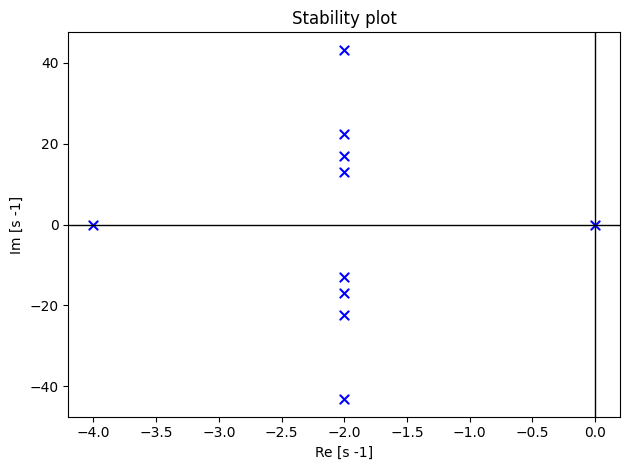

Status: Marginally stable
Eigenvalues: [-2.+43.20426368j -2.-43.20426368j -2.+22.386242j   -2.-22.386242j   -0. +0.j         -2.+16.83324676j -2.-16.83324676j -2.+12.95979951j -2.-12.95979951j -4. +0.j        ]
conjuage frequencies:   (0, 0)	6.876172126728632
  (0, 1)	3.5628810721836097
  (0, 3)	2.6790944307724693
  (0, 4)	2.0626161529856475


In [ ]:
#Let's make the system unstable by weakening some links, by increasing the X, and adding some more load
grid = gce.open_file('.\\networks\\case14.m')

#power flow
pf_options = gce.PowerFlowOptions(gce.SolverType.NR, verbose=False)
power_flow = gce.PowerFlowDriver(grid, pf_options)
power_flow.run()
res = power_flow.results

#initialization of variables
ss, init_guess = initialize_rms(grid, res)
params_mapping = {}

# The need of performing the power flow and initialization of variables 
# before the Stability assessment is noted.
# - If the Stability assessment time is not zero the dynamic simulation 
#   is performed before the Stability assessment:


t_assess = 20.0
h = 0.001
slv = BlockSolver(ss, grid.time)

params0 = slv.build_init_params_vector(params_mapping)
x0 = slv.build_init_vars_vector_from_uid(init_guess)

t, y = slv.simulate(
    t0=0,
    t_end=t_assess,
    h=h,
    x0=x0,
    params0=params0,
    method="implicit_euler",
)

(status, Eigenvalues,
 PFactors,
 damping_ratios,
 conjugate_frequencies) = run_small_signal_stability(slv=slv,
                                                     x=x0,
                                                     params=params0,
                                                     verbose = 0)


print("Status:",status)
print("Eigenvalues:",Eigenvalues)
print("conjuage frequencies:",conjugate_frequencies)

Compiling...done!
all compilation time = 44.865700 [s]
System bad initilaized. DAE resiudal is 10.440380977732962.
System bad initilaized. DAE resiudal is 12.983323003986179.
System bad initilaized. DAE resiudal is 3.561308638970088.
System bad initilaized. DAE resiudal is 1.5931657133292938.
System bad initilaized. DAE resiudal is 0.4934239798140705.
System bad initilaized. DAE resiudal is 0.050143159388495534.
System bad initilaized. DAE resiudal is 0.0011780569040289125.
System bad initilaized. DAE resiudal is 5.537105743873009e-07.
System well initailzed.
jacobian_total_time = 5.479645 [s]
functions_total_time = 0.595850 [s]
params_total_time = 0.022190 [s]
residual_total_time = 0.268211 [s]
solv_time = 3.962881 [s]


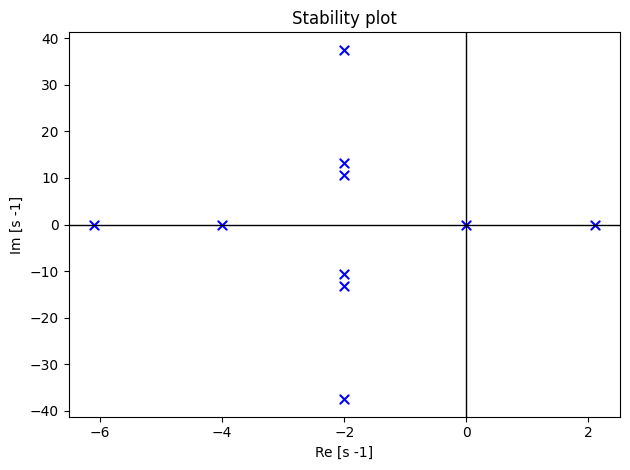

Status: Unstable
Eigenvalues: [-2.        +37.48806411j -2.        -37.48806411j -2.        +13.20148072j -2.        -13.20148072j -2.        +10.62786656j -2.        -10.62786656j  2.10647002 +0.j          0.         +0.j         -6.10647002 +0.j         -4.         +0.j        ]
conjuage frequencies:   (0, 0)	5.9664107100101695
  (0, 1)	2.1010809134973716
  (0, 2)	1.6914774970945985


In [ ]:
#Let's make the system unstable by weakening some links, by increasing the X, and adding some more load
grid = gce.open_file('.\\networks\\case14.m')
grid.loads[9].P *= 100
grid.lines[2].X *= 10

#power flow
pf_options = gce.PowerFlowOptions(gce.SolverType.NR, verbose=False)
power_flow = gce.PowerFlowDriver(grid, pf_options)
power_flow.run()
res = power_flow.results

#initialization of variables
ss, init_guess = initialize_rms(grid, res)
params_mapping = {}

# The need of performing the power flow and initialization of variables 
# before the Stability assessment is noted.
# - If the Stability assessment time is not zero the dynamic simulation 
#   is performed before the Stability assessment:


t_assess = 20.0
h = 0.001
slv = BlockSolver(ss, grid.time)

params0 = slv.build_init_params_vector(params_mapping)
x0 = slv.build_init_vars_vector_from_uid(init_guess)

t, y = slv.simulate(
    t0=0,
    t_end=t_assess,
    h=h,
    x0=x0,
    params0=params0,
    method="implicit_euler",
)

(status, Eigenvalues,
 PFactors,
 damping_ratios,
 conjugate_frequencies) = run_small_signal_stability(slv=slv,
                                                     x=x0,
                                                     params=params0,
                                                     verbose = 0)


print("Status:",status)
print("Eigenvalues:",Eigenvalues)
print("conjuage frequencies:",conjugate_frequencies)
